This jupyter nodebook is for implementation of the proposed method based on LSTM and evaluate the prformance of it with the Stack Overflow comments dataset.

# Load data

In [76]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/SE\ project/dataset/EMTK_datasets-v1.0.zip

Archive:  /content/drive/MyDrive/SE project/dataset/EMTK_datasets-v1.0.zip
c200f78878252a3779c76f19be2f0230c38ef00b
   creating: collab-uniba-EMTK_datasets-c200f78/
  inflating: collab-uniba-EMTK_datasets-c200f78/LICENSE  
  inflating: collab-uniba-EMTK_datasets-c200f78/README.md  
   creating: collab-uniba-EMTK_datasets-c200f78/jira/
   creating: collab-uniba-EMTK_datasets-c200f78/jira/emotions/
  inflating: collab-uniba-EMTK_datasets-c200f78/jira/emotions/README.md  
  inflating: collab-uniba-EMTK_datasets-c200f78/jira/emotions/anger.csv  
  inflating: collab-uniba-EMTK_datasets-c200f78/jira/emotions/joy.csv  
  inflating: collab-uniba-EMTK_datasets-c200f78/jira/emotions/love.csv  
  inflating: collab-uniba-EMTK_datasets-c200f78/jira/emotions/sadness.csv  
   creating: collab-uniba-EMTK_datasets-c200f78/so/
   creating: collab-uniba-EMTK_datasets-c200f78/so/emotions/
  inflating: collab-uniba-EMTK_datasets-c200f78/so/emotions/Emotion Annotation Guidelines.pdf  
  inflating: collab-un

In [3]:
import pandas as pd
df = pd.read_excel('/content/collab-uniba-EMTK_datasets-c200f78/so/emotions/Emotions_GoldSandard_andAnnotation.xlsx',sheet_name=None)

In [4]:
df

{'Anger_all':      Group     Set  Unnamed: 2  ... Gold Label Unnamed: 8 Unnamed: 9
 0        A  Second           1  ...        NaN        NaN        NaN
 1        A  Second           2  ...        NaN        NaN        NaN
 2        A  Second           3  ...        NaN        NaN        NaN
 3        A  Second           4  ...        NaN        NaN        NaN
 4        A  Second           5  ...        NaN        NaN        NaN
 ...    ...     ...         ...  ...        ...        ...        ...
 4795     D   Third         496  ...        NaN        NaN        NaN
 4796     D   Third         497  ...        NaN        NaN        NaN
 4797     D   Third         498  ...        NaN        NaN        NaN
 4798     D   Third         499  ...        NaN        NaN        NaN
 4799     D   Third         500  ...        NaN        NaN        NaN
 
 [4800 rows x 10 columns],
 'Fear_all':      Group     Set  Unnamed: 2  ... Gold Label Unnamed: 8 Unnamed: 9
 0        A  Second           1  ...

In [5]:
df["Love_all"]

,Group,Set,Unnamed: 2,Text,rater 1,rater 2,rater 3,Gold Label,Unnamed: 8,Unnamed: 9
0,A,Second,1,SVG transform on text attribute works excellen...,X,NaN,X,LOVE,NaN,NaN
1,A,Second,2,Excellent! This is exactly what I needed. Thanks!,X,x,X,LOVE,NaN,NaN
2,A,Second,3,Have added a modern solution as of May 2014 in...,NaN,NaN,NaN,NaN,NaN,NaN
3,A,Second,4,Have you tried removing 'preload' attribute? (...,NaN,NaN,NaN,NaN,NaN,NaN
4,A,Second,5,"A smarter, entirely C++-way of doing what you ...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4795,D,Third,496,Yes - that feature is extremely useful for wri...,NaN,NaN,x,NaN,NaN,NaN
4796,D,Third,497,"Works great! And you can add ""desc"" after the ...",x,NaN,x,LOVE,NaN,NaN
4797,D,Third,498,"Yeah, I didn't know about the non-greedy thing...",x,NaN,NaN,NaN,NaN,NaN
4798,D,Third,499,Fortunately I'm doing *very* little with Offic...,x,X,x,LOVE,NaN,NaN


In [11]:
text = []
neutral_emotional = []
label_sets = []

for i in range(4800):
  
  label = 0
  label_set = []
  for sheet in ['Love_all', 'Joy_all', 'Anger_all', 'Sadness_all', 'Fear_all', 'Surprise_all']:
    gold_label = df[sheet].loc[i].iat[7]
    if gold_label in ['LOVE', 'JOY', 'ANGER', 'SADNESS', 'FEAR', 'SURPRISE']:
      label = 1
      label_set.append(gold_label)
  if not 'SURPRISE' in label_set:
    neutral_emotional.append(label)
    label_sets.append(label_set)
    text.append(df['Love_all'].loc[i].iat[3])
  

In [13]:
def not_both(label_set,i):
  positive = ['LOVE','JOY']
  negative = ['SADNESS', 'FEAR', 'ANGER']
  is_positive = False
  is_negative = False
  for label in label_set:
    if label in positive:
      is_positive = True
    elif label in negative:
      is_negative = True
  if is_negative and is_positive:
    return False
  else:
    return True

def find_semantic(label_set):
  positive = ['LOVE','JOY']
  negative = ['SADNESS', 'FEAR', 'ANGER']
  if label_set[0] in positive:
    return 1
  return 0

In [15]:
text_semantic = []
semantic = []

for i in range(4755):
  if neutral_emotional[i]:
    if not_both(label_sets[i],i):
      text_semantic.append(df['Love_all'].loc[i].iat[3])
      semantic.append(find_semantic(label_sets[i]))


In [16]:
text_all = []
three_cat = []

for i in range(4755):
  if neutral_emotional[i]==0:
    text_all.append(text[i])
    three_cat.append('Neutral')
for i in range(len(text_semantic)):
  text_all.append(text_semantic[i])
  if semantic[i]:
    three_cat.append('Positive')
  else:
    three_cat.append('Negative')

In [17]:
len(text_all)

4730

# Model design

In [10]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM, Bidirectional
from tensorflow.keras.layers import TextVectorization
from keras.callbacks import ModelCheckpoint

In [31]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example
data = three_cat
values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

['Neutral' 'Neutral' 'Neutral' ... 'Positive' 'Positive' 'Positive']
[1 1 1 ... 2 2 2]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [30]:
len(text_all)*0.7

3311.0

In [32]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing. sequence import pad_sequences

maxlen = 100 # cut point in the review
training_samples = 3311 # train size
validation_samples = 4730-3311 # Validates size
max_words = 10000 # Considers only the top 10000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(text_all)
sequences = tokenizer.texts_to_sequences(text_all)
word_index = tokenizer.word_index               

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(onehot_encoded)

indices = np.arange(data.shape[0]) # Splits data into training and validation set, but shuffles is, since samples are ordered: 
# all negatives first, then all positive
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
labels = np.asarray(labels).astype(np.float32)

X_train = data[:training_samples] 
y_train = labels[:training_samples]
X_test = data[training_samples:training_samples+validation_samples] 
y_test = labels[training_samples:training_samples+validation_samples]

In [33]:
# word embedding subsection
embeddings_index = {}

f = open("drive/MyDrive/glove.6B.100d.txt", encoding='utf-8') #added , encoding='utf-8'
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print("found %s word vectors." % len (embeddings_index))

found 400000 word vectors.


In [34]:
embedding_dim = 100 # GloVe contains 100-dimensional embedding vectors for 400.000 words

embedding_matrix = np.zeros((max_words, embedding_dim)) # embedding_matrix.shape (10000, 100)
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word) # embedding_vector.shape (100,)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # Words not found in the mebedding index will all be zeros

In [24]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM, GRU
from keras.layers import Flatten, Dense
from keras.callbacks import ModelCheckpoint
histories = []

In [124]:
d= 80

# built the model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(LSTM(d))
model.add(Dense(3, activation = "softmax"))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# compile
model.compile(optimizer = "rmsprop",
            loss = "categorical_crossentropy",
            metrics = ["acc"])

# Test the model performance

In [125]:
# fit the model
mcp_save = ModelCheckpoint('model_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(X_train, y_train, epochs=15, batch_size=8, validation_data=(X_test,y_test), callbacks=[mcp_save])

Epoch 1/15
418/418 [==============================] - 28s 62ms/step - loss: 0.8647 - acc: 0.6041 - val_loss: 0.8783 - val_acc: 0.5855
Epoch 2/15
418/418 [==============================] - 23s 54ms/step - loss: 0.6897 - acc: 0.7089 - val_loss: 0.6261 - val_acc: 0.7341
Epoch 3/15
418/418 [==============================] - 23s 54ms/step - loss: 0.5937 - acc: 0.7588 - val_loss: 0.6448 - val_acc: 0.7139
Epoch 4/15
418/418 [==============================] - 22s 54ms/step - loss: 0.5403 - acc: 0.7882 - val_loss: 0.5739 - val_acc: 0.7753
Epoch 5/15
418/418 [==============================] - 23s 54ms/step - loss: 0.5023 - acc: 0.8121 - val_loss: 0.5376 - val_acc: 0.7920
Epoch 6/15
418/418 [==============================] - 22s 53ms/step - loss: 0.4768 - acc: 0.8202 - val_loss: 0.5308 - val_acc: 0.8004
Epoch 7/15
418/418 [==============================] - 23s 54ms/step - loss: 0.4481 - acc: 0.8247 - val_loss: 0.5135 - val_acc: 0.8018
Epoch 8/15
418/418 [==============================] - 23s 54ms

In [126]:
from keras.models import load_model
model = load_model('/content/model_best.hdf5')

In [127]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test_1 = np.argmax(y_test, axis=1)

In [128]:
from sklearn.metrics import classification_report
#y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77       374
           1       0.78      0.76      0.77       573
           2       0.88      0.85      0.87       486

    accuracy                           0.80      1433
   macro avg       0.80      0.80      0.80      1433
weighted avg       0.80      0.80      0.80      1433



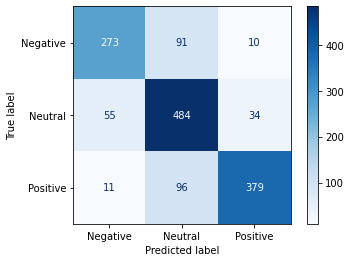

In [123]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusion_matrix(y_test_1, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test_1, y_pred, display_labels = ["Negative","Neutral","Positive"] ,cmap = 'Blues')